# Overview

This report is to construct a model to predict a home's current market value, and it is a Regression problem. We nned to do some data pre-processing first, following are steps:

- Missing value imputation & Feature selection
- One-hot-encoding for the categorical data and some ordinal features
- Remove outliers
- Log-tansform the feature (if needed)
- Normalize the feature scale before modeling

- Modeling 
  (Random forest, XGBoost,
  tuning the parameter by RandomizeCV)

- Evaluate each model with MAE

# Import Modules and Data
Lets import some useful modules and the read the data from our folder.

In [321]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn import neighbors
# plt.style.use("ggplot") # ggplot in R
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [322]:
training_2016 = pd.read_csv('train_2016_v2.csv')
properties_2016 = pd.read_csv('properties_2016.csv')

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merge the Tables Together
The predictors are in the properties_2016 data frame, but the dependent variables are in the train_2016 data frame, so we need to merge these two tables together.

In [323]:
merged_16 = pd.merge(training_2016, properties_2016, on='parcelid', how = 'left')
print(merged_16.head(10))

   parcelid  logerror transactiondate  airconditioningtypeid  \
0  11016594    0.0276      2016-01-01                    1.0   
1  14366692   -0.1684      2016-01-01                    NaN   
2  12098116   -0.0040      2016-01-01                    1.0   
3  12643413    0.0218      2016-01-02                    1.0   
4  14432541   -0.0050      2016-01-02                    NaN   
5  11509835   -0.2705      2016-01-02                    1.0   
6  12286022    0.0440      2016-01-02                    NaN   
7  17177301    0.1638      2016-01-02                    NaN   
8  14739064   -0.0030      2016-01-02                    NaN   
9  14677559    0.0843      2016-01-03                    NaN   

   architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                       NaN           NaN          2.0         3.0   
1                       NaN           NaN          3.5         4.0   
2                       NaN           NaN          3.0         2.0   
3              

In [324]:
merged_16["parcelid"]

0        11016594
1        14366692
2        12098116
3        12643413
4        14432541
           ...   
90270    10774160
90271    12046695
90272    12995401
90273    11402105
90274    12566293
Name: parcelid, Length: 90275, dtype: int64

# Check Missing Values

In [325]:
merged_16.shape

(90275, 60)

In [326]:
## Check missing value in row dimension 
row_missing=merged_16.isnull().sum(axis=1)/merged_16.shape[1]
len(row_missing[row_missing>0.8])

## Great! There's no row has more than 80% of missing values.

0

In [327]:
## Check missing value in column dimension
column_missing=merged_16.isnull().sum(axis=0)/merged_16.shape[0]
len(column_missing[column_missing>0.9])


20

In [328]:
column_missing

parcelid                        0.000000
logerror                        0.000000
transactiondate                 0.000000
airconditioningtypeid           0.681185
architecturalstyletypeid        0.997109
basementsqft                    0.999524
bathroomcnt                     0.000000
bedroomcnt                      0.000000
buildingclasstypeid             0.999823
buildingqualitytypeid           0.364564
calculatedbathnbr               0.013093
decktypeid                      0.992711
finishedfloor1squarefeet        0.924054
calculatedfinishedsquarefeet    0.007322
finishedsquarefeet12            0.051831
finishedsquarefeet13            0.999634
finishedsquarefeet15            0.960521
finishedsquarefeet50            0.924054
finishedsquarefeet6             0.995336
fips                            0.000000
fireplacecnt                    0.893581
fullbathcnt                     0.013093
garagecarcnt                    0.668380
garagetotalsqft                 0.668380
hashottuborspa  

Let's see what those columns mean by merging missing columns with data dictionary.

In [329]:
# Change "column_missing" to data frame and rename the index column
column_missing_df=pd.DataFrame(merged_16.isnull().sum(axis=0)/merged_16.shape[0],columns=["missing"])
column_missing_df.reset_index(level=0,inplace=True)
column_missing_df.rename(columns={"index":"Feature"},inplace=True)

In [330]:
# Remove the quotation mark in the feature column in dictionaty table
rm_quote=lambda x:x.replace("'","")
pd.set_option('display.max_colwidth',100)
dictionary=pd.read_excel("zillow_data_dictionary.xlsx",converters={"Feature":rm_quote})

In [331]:
# Now we can successfully join column_missing_df with dictionary
dic=pd.merge(column_missing_df,dictionary,how="left",on="Feature")
print(dic[dic["missing"]>0.8].sort_values(by="missing",ascending=False))

                     Feature   missing  \
8        buildingclasstypeid  0.999823   
15      finishedsquarefeet13  0.999634   
5               basementsqft  0.999524   
43               storytypeid  0.999524   
48        yardbuildingsqft26  0.998948   
51             fireplaceflag  0.997541   
4   architecturalstyletypeid  0.997109   
45    typeconstructiontypeid  0.996688   
18       finishedsquarefeet6  0.995336   
11                decktypeid  0.992711   
30               poolsizesum  0.989266   
31              pooltypeid10  0.987139   
32               pooltypeid2  0.986663   
57        taxdelinquencyflag  0.980249   
58        taxdelinquencyyear  0.980249   
24            hashottuborspa  0.973802   
47        yardbuildingsqft17  0.970690   
16      finishedsquarefeet15  0.960521   
17      finishedsquarefeet50  0.924054   
12  finishedfloor1squarefeet  0.924054   
20              fireplacecnt  0.893581   
44       threequarterbathnbr  0.866973   
33               pooltypeid7  0.81

# Missing Value Imputation

## Identifying Numerical / Categorical Features

In [332]:
# Although there are a lot of columns that are automatically identified as numerical feature, they are categorical features in nature.
merged_16.dtypes

parcelid                          int64
logerror                        float64
transactiondate                  object
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object


In [333]:
# So we need to manually identify numerical / categorical
catcols = ['parcelid','transactiondate','airconditioningtypeid','architecturalstyletypeid',
           'buildingqualitytypeid','buildingclasstypeid','decktypeid','fips',
           'hashottuborspa','heatingorsystemtypeid','propertycountylandusecode',
           'propertylandusetypeid','propertyzoningdesc','rawcensustractandblock',
           'regionidcity','regionidcounty','regionidneighborhood','regionidzip',
           'pooltypeid10', 'pooltypeid7', 'pooltypeid2',
           'storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag',"taxdelinquencyyear"]
numcols = [x for x in merged_16.columns if x not in catcols]

merged_16[catcols]=merged_16[catcols].astype(object)
merged_16.dtypes

parcelid                         object
logerror                        float64
transactiondate                  object
airconditioningtypeid            object
architecturalstyletypeid         object
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid              object
buildingqualitytypeid            object
calculatedbathnbr               float64
decktypeid                       object
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                             object
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object


## Heat Map

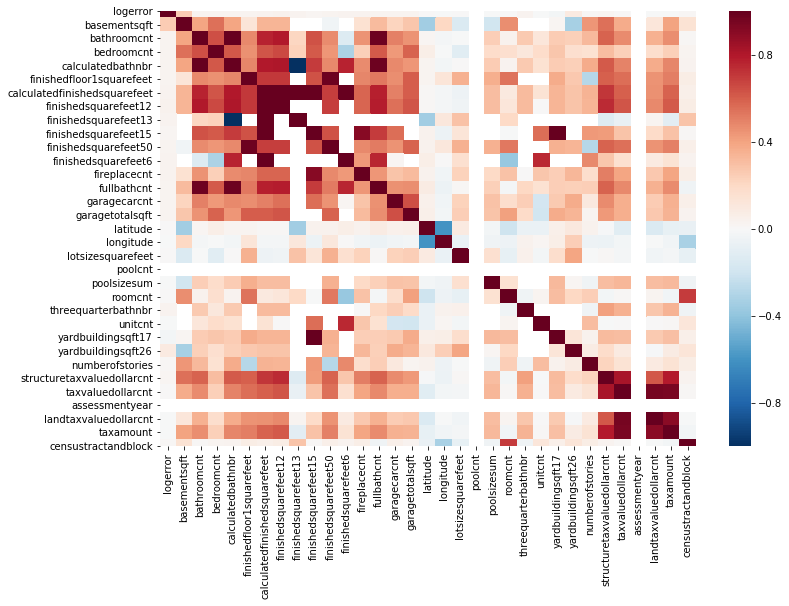

<Figure size 432x288 with 0 Axes>

In [334]:
#Lets start by plotting a heatmap to determine if any variables are correlated
plt.figure(figsize = (12,8))
sns.heatmap(data=merged_16[numcols].corr(), center=0.0,  cmap="RdBu_r")
plt.show()
plt.gcf().clear()

## Finished squre feet?
finishedsquarefeet6/12/13/15 all have missing value rate greater than 80%. And from the heat map, we can see that they are highly correlated with calculatedfinishedsquarefeet (whose missing value is less than 1%).

In [335]:
# So we can drop those columns.
merged_16.drop(['finishedsquarefeet6','finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15'],axis=1,inplace=True)

As for column finishedsquarefeet50 and finishedfloor1quarefeet, they have the same missing rates and they are highly correlated. Let's check what happened.

In [336]:
merged_16["minus"]= merged_16.apply(lambda x: x.loc["finishedsquarefeet50"] -x.loc["finishedfloor1squarefeet"],axis=1)
merged_16["minus"][merged_16["minus"].notnull()].describe()

count    6856.000000
mean        7.572637
std       133.696460
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4660.000000
Name: minus, dtype: float64

In [337]:
# We can see that these two rows have the same values for most of the rows. So drop one of them.
merged_16.drop(["minus"],axis=1,inplace=True)
merged_16.drop(['finishedsquarefeet50'],axis=1,inplace=True)

## Bath Room Count?

In [338]:
#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' are highly correlated and have the same information according to the dictionarys. 
# Choose 'bathroomcnt' as has no missing values, so remove the other two
merged_16.drop(['calculatedbathnbr','fullbathcnt'],axis=1,inplace=True)

## Fireplace Count?

In [339]:
merged_16["fireplacecnt"].describe()

count    9607.000000
mean        1.187884
std         0.484173
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: fireplacecnt, dtype: float64

In [340]:
# There's no 0 in the column " fireplacecnt", then we can assume that the null mean 0 due to "Number of pools on the lot (if any)" . 
# So impute 0 for missing valules
merged_16['fireplacecnt'].fillna(0, inplace=True)

## Garage?

In [341]:
print(merged_16["garagecarcnt"].describe())
print(merged_16["garagetotalsqft"].describe())

count    29937.000000
mean         1.812005
std          0.608761
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         24.000000
Name: garagecarcnt, dtype: float64
count    29937.000000
mean       345.521228
std        267.015918
min          0.000000
25%          0.000000
50%        433.000000
75%        484.000000
max       7339.000000
Name: garagetotalsqft, dtype: float64


In [342]:
# Garages are common in American houses, so we prefer not assume null value as zero.
# Impute null value as median
merged_16['garagecarcnt'].fillna(2, inplace=True)
merged_16['garagetotalsqft'].fillna(433, inplace=True)

## Lot Size?

In [343]:
print(merged_16["lotsizesquarefeet"].describe())
merged_16["lotsizesquarefeet"].fillna(7.200000e+03, inplace=True)

count    8.012500e+04
mean     2.911016e+04
std      1.217213e+05
min      1.670000e+02
25%      5.703000e+03
50%      7.200000e+03
75%      1.168600e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64


## calculatedfinishedsquarefeet?

In [344]:
merged_16["calculatedfinishedsquarefeet"][merged_16["calculatedfinishedsquarefeet"].isnull()]

126     NaN
174     NaN
231     NaN
293     NaN
299     NaN
         ..
88937   NaN
89637   NaN
89752   NaN
89840   NaN
89999   NaN
Name: calculatedfinishedsquarefeet, Length: 661, dtype: float64

In [345]:
# There's only 661 missing values in calculatedfinishedsquarefeet, so we could simply impute median value
merged_16["calculatedfinishedsquarefeet"].fillna(merged_16["calculatedfinishedsquarefeet"].mean(), inplace=True)

## Pool?
Now let's try to handle the missing values in pool related features. Due to the heatmap, it is easy to see that poolcnt has no correlation with any other features because it consist of only 1 value.

In [346]:
print(merged_16['poolcnt'].describe())
print(merged_16['pooltypeid10'].describe())

count    17901.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: poolcnt, dtype: float64
count     1161.0
unique       1.0
top          1.0
freq      1161.0
Name: pooltypeid10, dtype: float64


We can assume that the null mean 0 due to "Number of pools on the lot (if any)" . We impute 0 here and also handle the other pool related features.

In [347]:
merged_16['poolcnt'].fillna(0,inplace=True)

merged_16['pooltypeid10'].fillna(0,inplace=True)

merged_16['pooltypeid2'].fillna(0,inplace=True)

merged_16['pooltypeid7'].fillna(0,inplace=True)

Now, let's see the pool size feature. There are a lot of missing values, but we can see that it is close to nomally distributed. We will inpute the missing value with the median size, only when the property has a pool.

count     969.000000
mean      519.827657
std       155.054210
min        28.000000
25%       420.000000
50%       500.000000
75%       600.000000
max      1750.000000
Name: poolsizesum, dtype: float64


E:\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


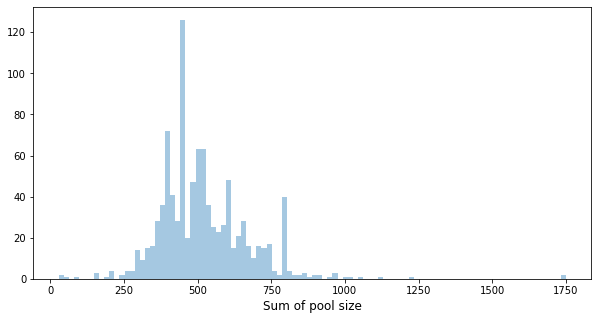

In [348]:
print(merged_16[merged_16['poolcnt'] > 0]['poolsizesum'].describe())
plt.figure(figsize=(10,5))
sns.distplot(merged_16['poolsizesum'], bins=100, kde=False)
plt.xlabel('Sum of pool size', fontsize=12)
plt.show()

In [349]:
#Fill in those properties that have a pool with median, and that have no pool with 0 for poolsize
merged_16.loc[merged_16['poolcnt'] > 0,['poolsizesum']].fillna(merged_16["poolsizesum"].median())
merged_16.loc[merged_16['poolcnt'] == 0,['poolsizesum']].fillna(0)

,poolsizesum
0,0.0
1,0.0
2,0.0
3,0.0
5,0.0
...,...
90269,0.0
90271,0.0
90272,0.0
90273,0.0


## Geographical Features (KNN Method fill NA)
There are several features geographically related, let's pick them out first.

Those columns obviously contain Geographic Information :

- latitude, longitude
- propertycountylandusecode, propertyzoningdesc
- regionidcity, regionidcounty, regionidneighborhood, regionidzip

And there are also several features that may be related to geographical information, which means their distribution may have some geographical pattern.
- censustractandblock, rawcensustractandblock
- propertylandusetypeid, 
- yearbuilt
- heatingorsystemtypeid, airconditioningtypeid

There are several features that provide mostly the same information, such as 'censustractandblock', "rawcensustractandblock", 'regionidcity', 'regionidcounty', 'regionidneighborhood' and 'propertyzoningdesc', they are all systems for making devisions of areas. We will keep the Zipcode for this.

In [350]:
merged_16.drop(['censustractandblock',"rawcensustractandblock", 'regionidcity', 'regionidcounty', 'regionidneighborhood','propertyzoningdesc'],axis=1,inplace=True)

In [351]:
geo_col = [  'latitude', 'longitude'
                            ,'propertycountylandusecode', 'propertylandusetypeid','buildingqualitytypeid'
                            ,  'regionidzip', 'yearbuilt', 'heatingorsystemtypeid', 'airconditioningtypeid']

# group these as a new dataframe.
geo_merged_16 = merged_16[geo_col]

# change latitude & longtitude to the normal scale we use in life
merged_16["latitude"]=merged_16["latitude"]/1e6
merged_16["longitude"]=merged_16["longitude"]/1e6

### propertylandusetypeid

Since our assumption is that the distribution of these features may have some geographical patterns, we tend to impute missing value by geo distances. Lets see if our assumption make sense.

[31.0, 47.0, 246.0, 247.0, 248.0, 260.0, 261.0, 263.0, 264.0, 265.0]


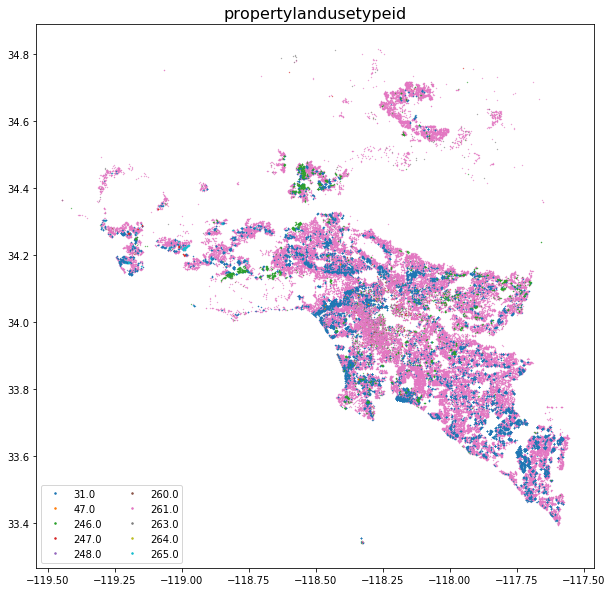

In [352]:
def plot_geo_feature(x_, y_, labeled_feature, title):
      # Generate Data
    df = pd.DataFrame(dict(x=x_, y=y_, label=labeled_feature))
    groups = df.groupby('label')
    uni_groups = [el[0] for el in groups.label.unique()]
    print(uni_groups[:10])

    # Plot
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(title, fontsize=16)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=0.3, label=name)
    ax.legend(uni_groups[:10], markerscale = 5, ncol=2, scatterpoints =1)
    plt.show()

#   Show the distribution of 'propertylandusetypeid'
plot_geo_feature(merged_16.longitude, merged_16.latitude, merged_16['propertylandusetypeid'], title='propertylandusetypeid')

Great! There are some geo relations, at least for property land use type. Now we can try to use K Nearest Neighbors to find the predicted value of missing values.

In [353]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    #  find if the target feature is missing     
    target_miss = df[target].isnull()
    
    # not missing     
    target_notmiss = ~target_miss
    
    # number of missing values     
    target_n_miss = target_miss.sum()
    
    if target_n_miss == 0 : 
        print ("Good news: no missing value :D ")
        return
    
    # Encode categorical features as a one-hot numeric array. check 
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    enc = OneHotEncoder(categories='auto')
    
    # get the non-missing base and targets as sample, e.g.'longtitude' 'latitude' 'buildingqualitytypeid'
    X_target = df.loc[ target_notmiss, whole ].sample( frac = fraction )
    
    # fit only targets to Encoder, e.g.'buildingqualitytypeid' (1 col)
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    # fit the non-missing targets to dummy variables Y and base as X 
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print("feature values: ", enc.categories_)
    
    # use existing values to train KNN Classifier     
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    # Using KNN Classifier to predict the missing target with base (e.g. Lon, lat)     
    print( 'predicting......' )
    Z = clf.predict(df.loc[target_miss, base])
    print('Horay! done! Z shape: ', Z.shape)
    print(Z)
    

    print( 'writing result to df' )    
    df.loc[ target_miss, target ]  = np.dot( Z , enc.categories_[0].T )
    return enc
    

### airconditioningtypeid

[False, True]


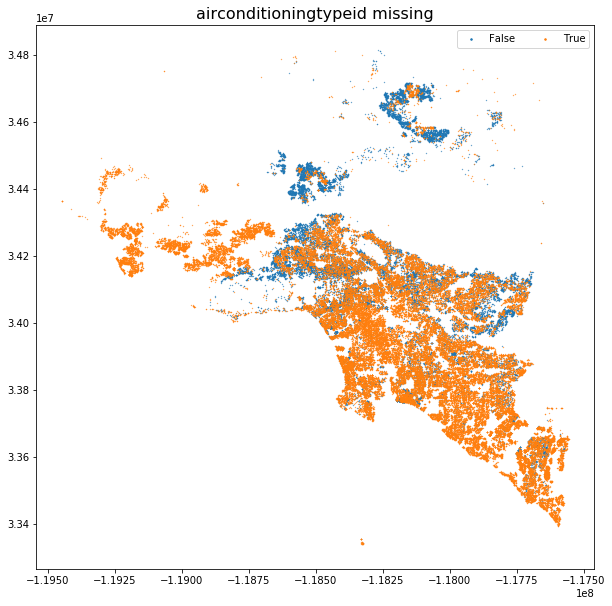

[1.0, 3.0, 5.0, 9.0, 11.0, 13.0]


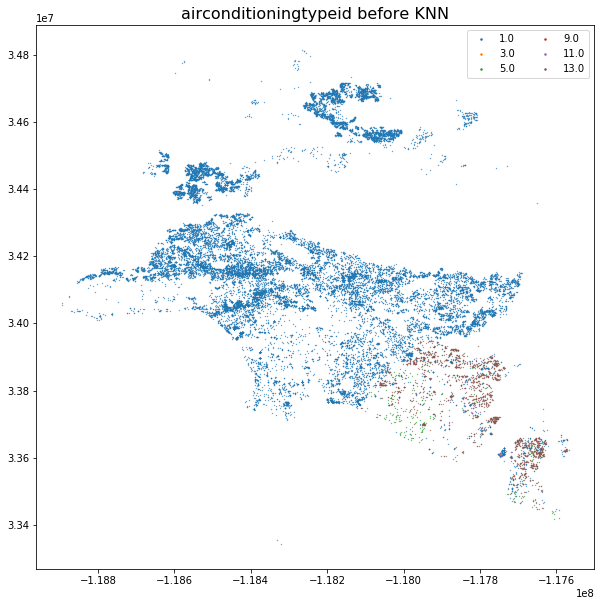

null:  61494
airconditioningtypeid
1.0     19319
3.0         1
5.0       215
9.0         1
11.0       45
13.0     1814
Name: latitude, dtype: int64
feature values:  [array([1.0, 3.0, 5.0, 9.0, 11.0, 13.0], dtype=object)]
predicting......
Horay! done! Z shape:  (61494, 6)
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
writing result to df
[0.0, 1.0, 3.0, 5.0, 9.0, 11.0, 13.0]


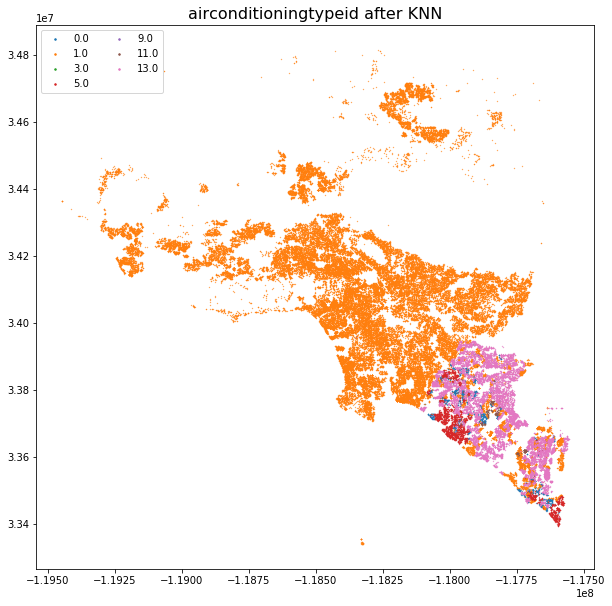

null:  0
airconditioningtypeid
0.0      1681
1.0     58626
3.0         1
5.0      2654
9.0         1
11.0      199
13.0    10910
Name: latitude, dtype: int64


In [354]:
# now we can impute missing values in geographical-related features using KNN momdel! 
base = ['longitude','latitude' ]
target = 'airconditioningtypeid'

missing_col = geo_merged_16[target].isnull()

# BEFORE 
# We can see in the graph "before KNN" that values do have geographical distribution pattern 
# To save space, this step is not going to be shown for every feature in the geo_col, but we've checked the distribution for all of them.
plot_geo_feature(geo_merged_16[base[0]], geo_merged_16[base[1]], missing_col, target + " missing")
plot_geo_feature(geo_merged_16[base[0]], geo_merged_16[base[1]], geo_merged_16[target], target + " before KNN")
print("null: ", geo_merged_16[target].isnull().sum())
feature_distribution= geo_merged_16.groupby(target)['latitude'].nunique()
print(feature_distribution)
# AFTER
fillna_knn( df = geo_merged_16, base = base , target = target, fraction = 1, n_neighbors = 5)
plot_geo_feature(geo_merged_16[base[0]], geo_merged_16[base[1]], geo_merged_16[target], target + " after KNN")
print("null: ", geo_merged_16[target].isnull().sum())
feature_distribution= geo_merged_16.groupby(target)['latitude'].nunique()
print(feature_distribution)

### regionidzip
In our opinion, this is the most important regional data we have here, because Zip code is intuitive, has the least missing data, and not too many distinct values. However, lets see if we can bin/simplify the data even more by getting the first 4 digit without making it too rough.

[False]


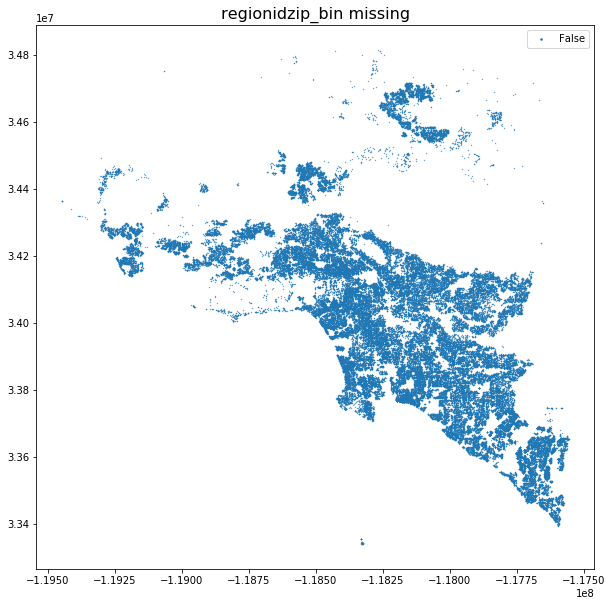

['0', '3996', '9598', '9599', '9600', '9601', '9602', '9603', '9604', '9605']


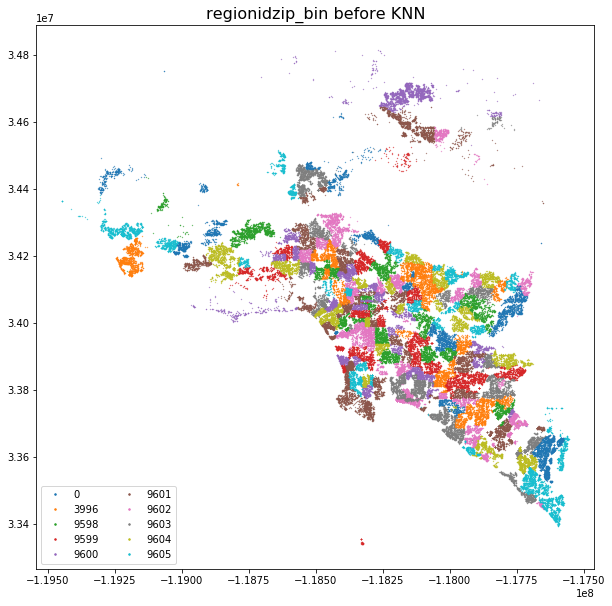

null:  0
distinct values: 78 
 regionidzip_bin
0         18
3996      13
9598    1099
9599     631
9600    1275
9601    1042
9602    2089
9603     412
9604    1535
9605     302
9607      30
9608     414
9609     828
9610    1336
9611     962
9612    2210
9613     273
9614     109
9615     510
9616     902
9617     890
9618    1300
9619    1373
9620     870
9621    1075
9622     998
9623    1040
9624    1481
9626     778
9627     853
9628     598
9629    1079
9632     681
9633    1124
9634     998
9635    1273
9636    1537
9637    2252
9638    1766
9639     604
9640     529
9641     999
9642     552
9643     637
9644     517
9645     515
9646     879
9647     742
9648    1164
9649     931
9650    1106
9651     965
9652     878
9653     293
9693     145
9694     923
9695    1380
9696    2595
9697    1569
9698    2554
9699    2234
9700    1480
9701     487
9702    1638
9703     535
9704    1112
9705     445
9706    1278
9707     653
9708    1370
9709    1207
9710    1303
9711    1327
9729

In [355]:
# create a feature as a binned zip code
base = ['longitude','latitude' ]
target = 'regionidzip_bin'

geo_merged_16['regionidzip'].fillna('0', inplace= True)
geo_merged_16[target] = geo_merged_16['regionidzip'].astype(str).apply(lambda x : x[0:4]).astype(object)
geo_merged_16[target].replace(0, np.NaN, inplace= True)
missing_col = geo_merged_16[target].isnull()

# Try binning and see the fraphic
plot_geo_feature(geo_merged_16[base[0]], geo_merged_16[base[1]], missing_col, target + " missing")
plot_geo_feature(geo_merged_16[base[0]], geo_merged_16[base[1]], geo_merged_16[target], target + " before KNN")
print("null: ", geo_merged_16[target].isnull().sum())
feature_distribution= geo_merged_16.groupby(target)['latitude'].nunique()
print('distinct values:', feature_distribution.shape[0], '\n', feature_distribution)


In [362]:
fillna_knn( df = geo_merged_16, base = base , target = target, fraction = 1, n_neighbors = 5 )

Good news: no missing value :D 


0        1960
1        2015
2        1940
3        1985
4        1980
         ... 
90270    1980
90271    1965
90272    1925
90273    1980
90274    1945
Name: yearbuilt, Length: 90275, dtype: object

### heatingorsystemtypeid

In [357]:
target = 'heatingorsystemtypeid'
fillna_knn( df = geo_merged_16, base = base , target = target, fraction = 1, n_neighbors = 5)


feature values:  [array([1.0, 2.0, 6.0, 7.0, 10.0, 11.0, 12.0, 13.0, 14.0, 18.0, 20.0, 24.0],
      dtype=object)]
predicting......
Horay! done! Z shape:  (34195, 12)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
writing result to df


OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

### yearbuilt

In [358]:
geo_merged_16['yearbuilt']=geo_merged_16['yearbuilt'].astype(float)
target="yearbuilt"
geo_merged_16[target] = round(geo_merged_16['yearbuilt']/5)*5
fillna_knn( df = geo_merged_16, base = base , target = target, fraction = 1, n_neighbors = 5 )
geo_merged_16['yearbuilt']=geo_merged_16['yearbuilt'].astype(object)

feature values:  [array([1885., 1890., 1895., 1900., 1905., 1910., 1915., 1920., 1925.,
       1930., 1935., 1940., 1945., 1950., 1955., 1960., 1965., 1970.,
       1975., 1980., 1985., 1990., 1995., 2000., 2005., 2010., 2015.])]
predicting......
Horay! done! Z shape:  (756, 27)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
writing result to df


### propertycountylandusecode

In [359]:
print(geo_merged_16['propertycountylandusecode'].isnull().sum())
geo_merged_16['propertycountylandusecode'].fillna(1,inplace=True)

1


### buildingqualitytypeid

In [360]:
target = 'buildingqualitytypeid'
fillna_knn( df = geo_merged_16, base = base , target = target, fraction = 1, n_neighbors = 5 )


feature values:  [array([1.0, 4.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0], dtype=object)]
predicting......
Horay! done! Z shape:  (32911, 8)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
writing result to df


OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

### Hooray! We finally finished imputing all the geo-related features

In [275]:
geo_merged_16.isnull().sum()

latitude                     0
longitude                    0
propertycountylandusecode    0
propertylandusetypeid        0
buildingqualitytypeid        0
regionidzip                  0
yearbuilt                    0
heatingorsystemtypeid        0
airconditioningtypeid        0
regionidzip_bin              0
yearbuilt_roundto5           0
dtype: int64

In [279]:
# write them back to the dataframe
merged_16[geo_col] = geo_merged_16[geo_col]

### threequarterbathnbr, unitcnt, numberofstories
We can assume that the quater bathrooms count are same as the median instead of 0 while they are NaN, because most houses has 1 or more quater bathrooms, numberofstories

In [281]:
target = 'threequarterbathnbr'
merged_16[target].fillna(merged_16[target].median(), inplace=True)
target = 'unitcnt'
merged_16[target].fillna(merged_16[target].median(), inplace=True)
target = 'numberofstories'
merged_16[target].fillna(merged_16[target].median(), inplace=True)

### Imputing Missing Data - Taxtative
There are some features tax related, let's pick them out:
- structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt	
We can see that taxvaluedollarcnt = structuretaxvaluedollarcnt + landtaxvaluedollarcnt
- assessmentyear
- taxamount	
- taxdelinquencyflag, taxdelinquencyyear 

In [283]:
merged_16['tax_total'] = merged_16['structuretaxvaluedollarcnt'] + merged_16['landtaxvaluedollarcnt']
display(merged_16[['tax_total', 'taxvaluedollarcnt']])
target = 'structuretaxvaluedollarcnt'
merged_16[target].fillna(merged_16[target].median(), inplace=True)
target = 'landtaxvaluedollarcnt'
merged_16[target].fillna(merged_16[target].median(), inplace=True)
target = 'taxvaluedollarcnt'
merged_16[target].fillna(merged_16[target].median(), inplace=True)
merged_16 = merged_16.drop('tax_total', axis=1)


,tax_total,taxvaluedollarcnt
0,360170.0,360170.0
1,585529.0,585529.0
2,119906.0,119906.0
3,244880.0,244880.0
4,434551.0,434551.0
...,...,...
90270,191000.0,191000.0
90271,161111.0,161111.0
90272,38096.0,38096.0
90273,165869.0,165869.0


In [284]:
merged_16['taxvaluedollarcnt'].corr(merged_16['taxamount'])

0.9493736443763908

We can also see that taxvaluedollarcnt & taxamount are highly correlated, so we will drop taxamount.
We will also drop taxdelinquencyflag, taxdelinquencyyear due having too many missing values.

In [289]:
merged_16.drop(["taxamount"],axis=1,inplace=True)

target = 'taxdelinquencyflag'
merged_16[target].fillna('none', inplace=True)
target = 'taxdelinquencyyear'
merged_16[target].fillna(0, inplace=True)


## Check the missing value rates again!

In [295]:
column_missing_df=pd.DataFrame(merged_16.isnull().sum(axis=0)/merged_16.shape[0],columns=["missing"])
column_missing_df.reset_index(level=0,inplace=True)
column_missing_df.rename(columns={"index":"Feature"},inplace=True)
dic=pd.merge(column_missing_df,dictionary,how="left",on="Feature")
print(dic.sort_values(by="missing",ascending=False))

                         Feature   missing  \
8            buildingclasstypeid  0.999823   
5                   basementsqft  0.999524   
32                   storytypeid  0.999524   
37            yardbuildingsqft26  0.998948   
40                 fireplaceflag  0.997541   
4       architecturalstyletypeid  0.997109   
34        typeconstructiontypeid  0.996688   
10                    decktypeid  0.992711   
24                   poolsizesum  0.989266   
18                hashottuborspa  0.973802   
36            yardbuildingsqft17  0.970690   
11      finishedfloor1squarefeet  0.924054   
13          finishedsquarefeet50  0.924054   
31                       roomcnt  0.000000   
30                   regionidzip  0.000000   
33           threequarterbathnbr  0.000000   
35                       unitcnt  0.000000   
0                       parcelid  0.000000   
38                     yearbuilt  0.000000   
39               numberofstories  0.000000   
28     propertycountylandusecode  

## Drop Features that have missing value > 90%

In [304]:
drop_90=dic[dic["missing"]>0.9]["Feature"].tolist()
merged_16.drop(drop_90,axis=1,inplace=True)

KeyError: "['architecturalstyletypeid' 'basementsqft' 'buildingclasstypeid'\n 'decktypeid' 'finishedfloor1squarefeet' 'finishedsquarefeet50'\n 'hashottuborspa' 'poolsizesum' 'storytypeid' 'typeconstructiontypeid'\n 'yardbuildingsqft17' 'yardbuildingsqft26' 'fireplaceflag'] not found in axis"

## Horay! Done with all the missing values!

In [310]:
column_missing=pd.DataFrame(merged_16.isnull().sum(axis=0)/merged_16.shape[0],columns=["missing"])
column_missing

,missing
parcelid,0.0
logerror,0.0
transactiondate,0.0
airconditioningtypeid,0.0
bathroomcnt,0.0
bedroomcnt,0.0
buildingqualitytypeid,0.0
calculatedfinishedsquarefeet,0.0
fips,0.0
fireplacecnt,0.0


# "Parcelid" & "Transactiondate"

In [311]:
# Since parcelid and transactiondate, as categorical feature, have too many levels, and they are ueseless for future prediction, we need to drop them too.
merged_16.drop(["parcelid","transactiondate"],axis=1,inplace=True)

In [314]:
merged_16.to_csv("merged_16_clean.csv", encoding='utf-8', index=False)